In [1]:
!pip install kaggle

In [1]:
#configure the path of the kaggle.json file
!mkdir -p ~/.kaggle  #make a directory of kaggle
!cp kaggle.json ~/.kaggle/ #copy the kaggle.json file into that directory
!chmod 600 ~/.kaggle/kaggle.json  # change file permissions to secure to enable only the current user to read and write

In [3]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
100% 80.9M/80.9M [00:00<00:00, 277MB/s]
100% 80.9M/80.9M [00:00<00:00, 269MB/s]


In [4]:
#Extract the zip file
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [5]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [10]:
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1')

In [11]:
#checking the number of rows and columns
twitter_data.shape

(1599999, 6)

In [12]:
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [13]:
#naming the columns and re reading
column_names = ['target','id','date','flag','user','text']
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',names = column_names,  encoding='ISO-8859-1')

In [14]:
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [15]:
twitter_data.shape

(1600000, 6)

In [16]:
#counting the number of missing values
twitter_data.isnull().sum()

,0
target,0
id,0
date,0
flag,0
user,0
text,0


In [17]:
twitter_data['target'].value_counts()

,count
target,
0,800000
4,800000


In [18]:
#convert the target 4 to 1
twitter_data['target'] = np.where(twitter_data['target']==4,1,twitter_data['target'])

In [19]:
twitter_data['target'].value_counts()

,count
target,
0,800000
1,800000


In [20]:
#Stemming : The process of reducing a word to its root word
#example , actor , acting , actress = act
# so it becomes easier of our model to work and gop through all the data and for that i will be using the Porter Stemmer function


In [21]:
port_stem  = PorterStemmer()



In [22]:
def stemming(Content) :
    stemmed_content = re.sub('[^a-zA-Z]',' ',Content)
    stemmed_content = stemmed_content.lower()
    stemmed_content =  stemmed_content.split()
    stemmed_content = [port_stem.stem( word) for word in stemmed_content
                       if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)

    return stemmed_content


In [ ]:
from tqdm import tqdm

# Enable progress bar for pandas apply
tqdm.pandas()

# Assuming twitter_data is your DataFrame and stemming is your function
twitter_data['stemmed_content'] = twitter_data['text'].progress_apply(stemming)


 84%|████████▎ | 1336973/1600000 [32:52<05:28, 799.59it/s]

In [25]:
twitter_data.head()


,target,id,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [30]:
print(twitter_data['stemmed_content'])

0          switchfoot http twitpic com zl awww bummer sho...
1          upset updat facebook text might cri result sch...
2          kenichan dive mani time ball manag save rest g...
3                            whole bodi feel itchi like fire
4                              nationwideclass behav mad see
                                 ...                        
1599995                           woke school best feel ever
1599996    thewdb com cool hear old walt interview http b...
1599997                         readi mojo makeov ask detail
1599998    happi th birthday boo alll time tupac amaru sh...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: stemmed_content, Length: 1600000, dtype: object


In [27]:
print(twitter_data['target'])


0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


In [31]:
X = twitter_data['stemmed_content']
Y = twitter_data['target']

Splitting the data into test and train  

In [32]:
X_train , X_test, Y_train, Y_test  =  train_test_split(X,Y,test_size = 0.2, stratify =Y, random_state = 3)

In [33]:
print(X.shape, X_train.shape, X_test.shape)

(1600000,) (1280000,) (320000,)


In [34]:
print(Y.shape , Y_train.shape, Y_test.shape)

(1600000,) (1280000,) (320000,)


In [35]:
#now because the ML model does not understand the extracted text data so we need to convert it to numerals
print(X_train)

560689                         arm fell comput chair go lean
858040                     chrishillfan got media next lucki
105514             suck havin watch yur mother sick cnt help
722701     pool awesom two hour got home took shower went...
1006092                finnstrip hehe madmoo proof read shit
                                 ...                        
178537       blehhh feel poopi fever whole bodi hurtssss fml
217814     http www newsoftheworld co uk look though kati...
1041451               melosm oooop sorri non exist miss call
1164330    frowzl accord j rg kachelmann start rain tomor...
1099378    alcarlton lol idea mate go buy cloth much simp...
Name: stemmed_content, Length: 1280000, dtype: object


In [36]:
print(X_test)

640938     hate dog bark someth noth happen scari time tr...
1205427                willi day either support cuz like guy
423149                             jordalynn yah pretti mess
98574                                    camillli miss youuu
625106     want grey anatomi come back channel agee sinc ...
                                 ...                        
177243                            begin think sun blcok haox
233048     meldraythecool na abl choos school get full ti...
912318     use spare usb flash drive virtual ram pc got g...
750873                          sistatreen jealou miss beach
822478     sakura kurosaki prob hope good one lt ooh kind...
Name: stemmed_content, Length: 320000, dtype: object


In [37]:
#convert the textual data to numerical data
vectorizer  =  TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [38]:
print(X_train)

  (0, 23107)	0.4171639689388593
  (0, 130345)	0.39805809775478695
  (0, 79295)	0.3591444105830402
  (0, 66262)	0.4703657150050708
  (0, 149604)	0.18999894424903024
  (0, 230023)	0.5302789468855067
  (1, 71762)	0.7464326512642685
  (1, 151539)	0.22265959091242624
  (1, 258288)	0.4279926445106241
  (1, 288268)	0.28409690701894913
  (1, 243427)	0.3596835378056311
  (2, 386886)	0.2747790530029926
  (2, 160639)	0.4212655595518347
  (2, 436235)	0.22572360152384552
  (2, 457071)	0.49837923199930634
  (2, 274638)	0.3245662122941834
  (2, 366626)	0.27374745700647773
  (2, 76994)	0.437205368032008
  (2, 163634)	0.2761690912767651
  (3, 151539)	0.19573397217293262
  (3, 320044)	0.3297045033341762
  (3, 28856)	0.2493882805802756
  (3, 421090)	0.27709210796096556
  (3, 170034)	0.24487082877971147
  (3, 168315)	0.21454573592450427
  :	:
  (1279998, 340490)	0.13694981469352294
  (1279998, 411972)	0.13146318169550325
  (1279998, 381528)	0.14384525058020728
  (1279998, 169151)	0.12422948295881117
  (12

In [39]:
print(X_test)

  (0, 33329)	0.5023175290684292
  (0, 105377)	0.3245022701383146
  (0, 159203)	0.3005025059321471
  (0, 160330)	0.26258695935360743
  (0, 294474)	0.29845502662571677
  (0, 354711)	0.3802742698812219
  (0, 371029)	0.24640479593431913
  (0, 375101)	0.2848834746101269
  (0, 408499)	0.21003368771385608
  (0, 415689)	0.25189227574438927
  (1, 87100)	0.39510766737101444
  (1, 93683)	0.21941299197386777
  (1, 115722)	0.392787042356637
  (1, 156037)	0.3169093785810737
  (1, 234202)	0.23372878235800623
  (1, 389414)	0.42351953294380973
  (1, 442056)	0.5541089394462928
  (2, 201868)	0.7477521990696273
  (2, 261613)	0.3834893477036243
  (2, 322579)	0.30380202466576606
  (2, 452062)	0.4488951980065795
  (3, 267239)	0.42627781280421434
  (3, 456101)	0.9045922983924057
  (4, 5866)	0.5634453148489608
  (4, 15952)	0.3757184238258157
  :	:
  (319997, 109190)	0.24069024607222428
  (319997, 133479)	0.3234603720074449
  (319997, 143703)	0.327821390817873
  (319997, 151539)	0.16087427025812226
  (319997, 2

Training the logistic regression machine learning model  

In [41]:
model = LogisticRegression(max_iter = 1000)

In [42]:
from tqdm import tqdm
# Enable progress bar for pandas apply
tqdm.pandas()
model.fit(X_train,Y_train)


LogisticRegression(max_iter=1000)

Model evaluation

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Predictions
X_train_prediction = model.predict(X_train)
Y_test_prediction = model.predict(X_test)

# Accuracy
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)
testing_data_accuracy = accuracy_score(Y_test, Y_test_prediction)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_test_prediction)

# Precision, Recall, and F1 Score
precision = precision_score(Y_test, Y_test_prediction, average='binary')
recall = recall_score(Y_test, Y_test_prediction, average='binary')
f1 = f1_score(Y_test, Y_test_prediction, average='binary')

# Print metrics
print(f'Training accuracy: {training_data_accuracy}')
print(f'Testing accuracy: {testing_data_accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')



Training accuracy: 0.8025671875
Testing accuracy: 0.777428125
Confusion Matrix:
[[121206  38794]
 [ 32429 127571]]
Precision: 0.7668139332191266
Recall: 0.79731875
F1 Score: 0.781768878403015


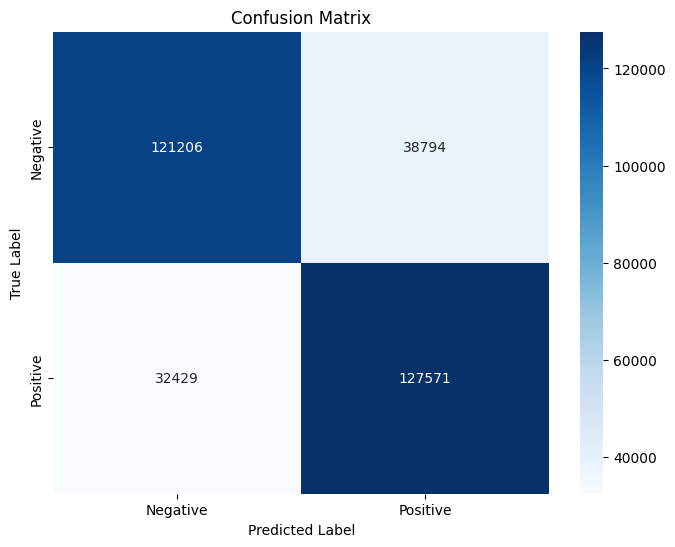

In [59]:
# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



<ipython-input-63-6c06a9ee4026>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


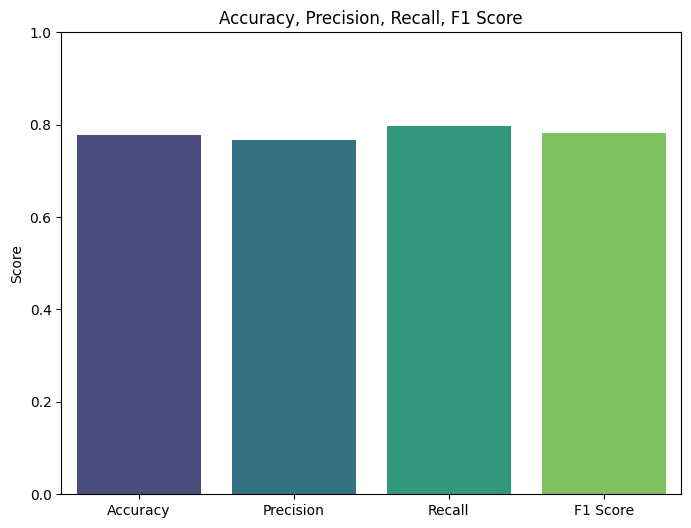

In [63]:
# Plotting Precision, Recall, and F1 Score as a Bar Chart
metrics = ['Accuracy','Precision', 'Recall', 'F1 Score']
values = [testing_data_accuracy,precision, recall, f1]

plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=values, palette='viridis')
plt.title('Accuracy, Precision, Recall, F1 Score')
plt.ylabel('Score')
plt.ylim(0, 1)  # Metrics are in the range 0-1
plt.show()






In [45]:
import pickle
filename = 'trained_model.sav'
pickle.dump(model, open(filename,'wb'))


In [46]:
#using the saved model for future predictions
loaded_model  = pickle.load(open('trained_model.sav','rb'))

In [53]:
X_new = X_test[136]
print(Y_test[136])

prediction = loaded_model.predict(X_new)
print(prediction)

if(prediction[0] == Y_test[136]):
  print("The model is working fine")
else:
  print("Model made an error")

0
[0]
The model is working fine
